# Visual analytics and diagnostics of model fit for linear regression

In this notebook, we show the basic visual analytics and diagnostic tests that should be run after fitting a linear regression model, for **checking the goodness of fit by verifying the fundamental assumptions of linear regression** - *linearity, independence, constant variance,* and *normality*. In particular, following analytics are shown,

* Pairwise scatterplot of the data matrix
* Correlation matrix and heatmap
* Creating a new dataset of predicting features and their statistical significance (based on p-values)
* Residuals vs. predicting variables plots
* Fitted vs. residuals plot
* Histogram of the normalized residuals
* Q-Q plot of the normalized residuals
* Shapiro-Wilk normality test on the residuals
* Cook's distance plot of the residuals
* Variance inflation factor (VIF) of the predicting features

### Requirements

* Python 3.6+
* `Numpy`
* `Pandas`
* `Seaborn`
* `Statsmodels`
* `Scipy`

### The dataset

We analyze the **[Concrete Compressive Strength Data Set](https://archive.ics.uci.edu/ml/datasets/Concrete+Compressive+Strength)** from UCI ML repository in this notebook.

***Abstract***: Concrete is the most important material in civil engineering. The concrete compressive strength is a highly nonlinear function of age and ingredients. Can we predict the strength from other measurement values?

#### Data Set Information:

* Number of instances: 1030 
* Number of Attributes: 9 
* Attribute breakdown	8 quantitative input variables, and 1 quantitative output variable 
* Missing Attribute Values: None 

### Import the libraries and read the data in

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [16]:
# The dataset path may be different in your situation. Please use the correct path
df = pd.read_excel("Concrete_Data.xls")

In [17]:
df.head(10)

,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),"Concrete compressive strength(MPa, megapascals)"
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075
5,266.0,114.0,0.0,228.0,0.0,932.0,670.0,90,47.029847
6,380.0,95.0,0.0,228.0,0.0,932.0,594.0,365,43.698299
7,380.0,95.0,0.0,228.0,0.0,932.0,594.0,28,36.447770
8,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.854291
9,475.0,0.0,0.0,228.0,0.0,932.0,594.0,28,39.289790


In [18]:
#.T transpose
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Cement (component 1)(kg in a m^3 mixture),1030.0,281.165631,104.507142,102.000000,192.375000,272.900000,350.000000,540.000000
Blast Furnace Slag (component 2)(kg in a m^3 mixture),1030.0,73.895485,86.279104,0.000000,0.000000,22.000000,142.950000,359.400000
Fly Ash (component 3)(kg in a m^3 mixture),1030.0,54.187136,63.996469,0.000000,0.000000,0.000000,118.270000,200.100000
Water (component 4)(kg in a m^3 mixture),1030.0,181.566359,21.355567,121.750000,164.900000,185.000000,192.000000,247.000000
Superplasticizer (component 5)(kg in a m^3 mixture),1030.0,6.203112,5.973492,0.000000,0.000000,6.350000,10.160000,32.200000
Coarse Aggregate (component 6)(kg in a m^3 mixture),1030.0,972.918592,77.753818,801.000000,932.000000,968.000000,1029.400000,1145.000000
Fine Aggregate (component 7)(kg in a m^3 mixture),1030.0,773.578883,80.175427,594.000000,730.950000,779.510000,824.000000,992.600000
Age (day),1030.0,45.662136,63.169912,1.000000,7.000000,28.000000,56.000000,365.000000
"Concrete compressive strength(MPa, megapascals)",1030.0,35.817836,16.705679,2.331808,23.707115,34.442774,46.136287,82.599225


### Taking a peek at the relationship between the predicting variables and the response

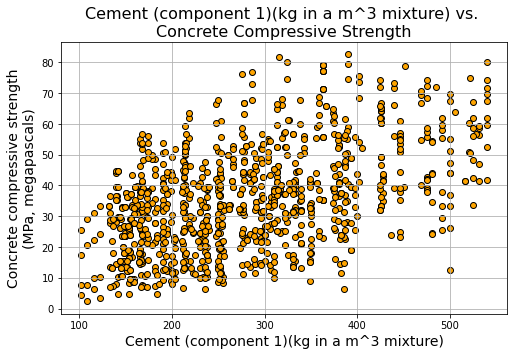

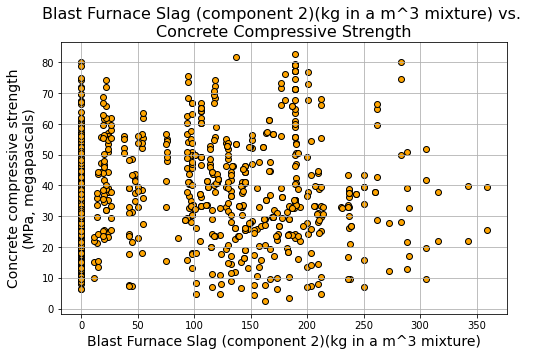

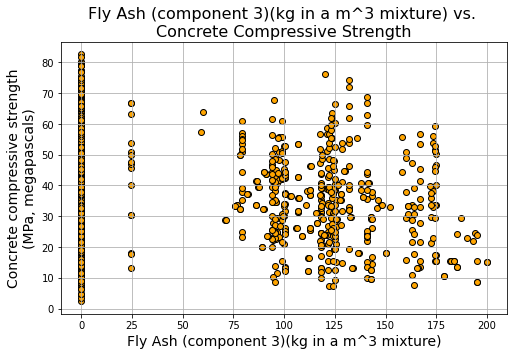

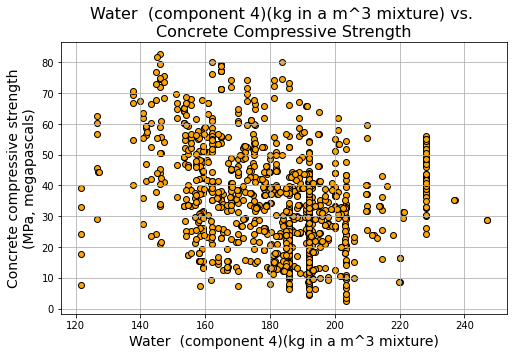

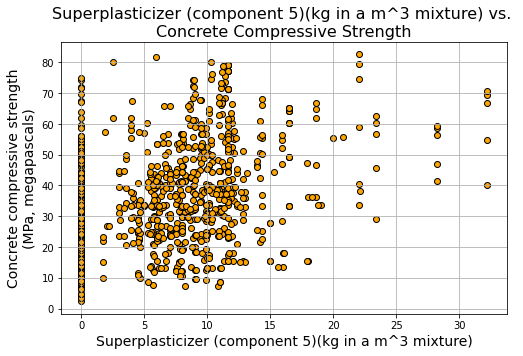

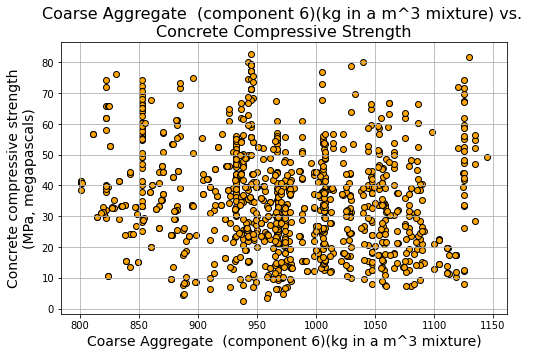

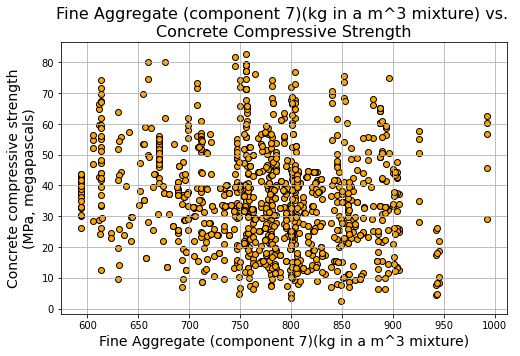

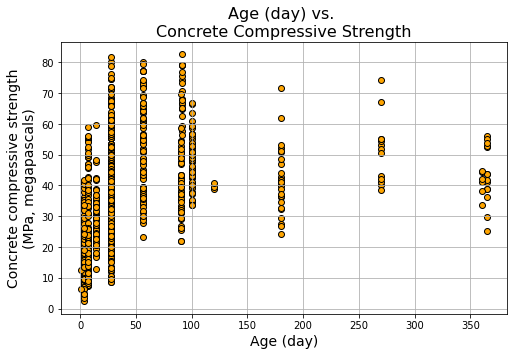

In [19]:
for c in df.columns[:-1]:
    plt.figure(figsize=(8,5))
    plt.title("{} vs. \nConcrete Compressive Strength".format(c),fontsize=16)
    plt.scatter(x=df[c],y=df['Concrete compressive strength(MPa, megapascals) '],color='orange',edgecolor='k')
    plt.grid(True)
    plt.xlabel(c,fontsize=14)
    plt.ylabel('Concrete compressive strength\n(MPa, megapascals)',fontsize=14)
    plt.show()

### Creating a copy with suitable column names for processing with `statsmodels.OLS()`

In [20]:
df1 = df.copy()

In [21]:
df1.columns=['Component'+str(i) for i in range(1,8)]+['Age']+['y']

In [22]:
df1.head()

,Component1,Component2,Component3,Component4,Component5,Component6,Component7,Age,y
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075


### Pairwise scatter plots

In [23]:
from seaborn import pairplot

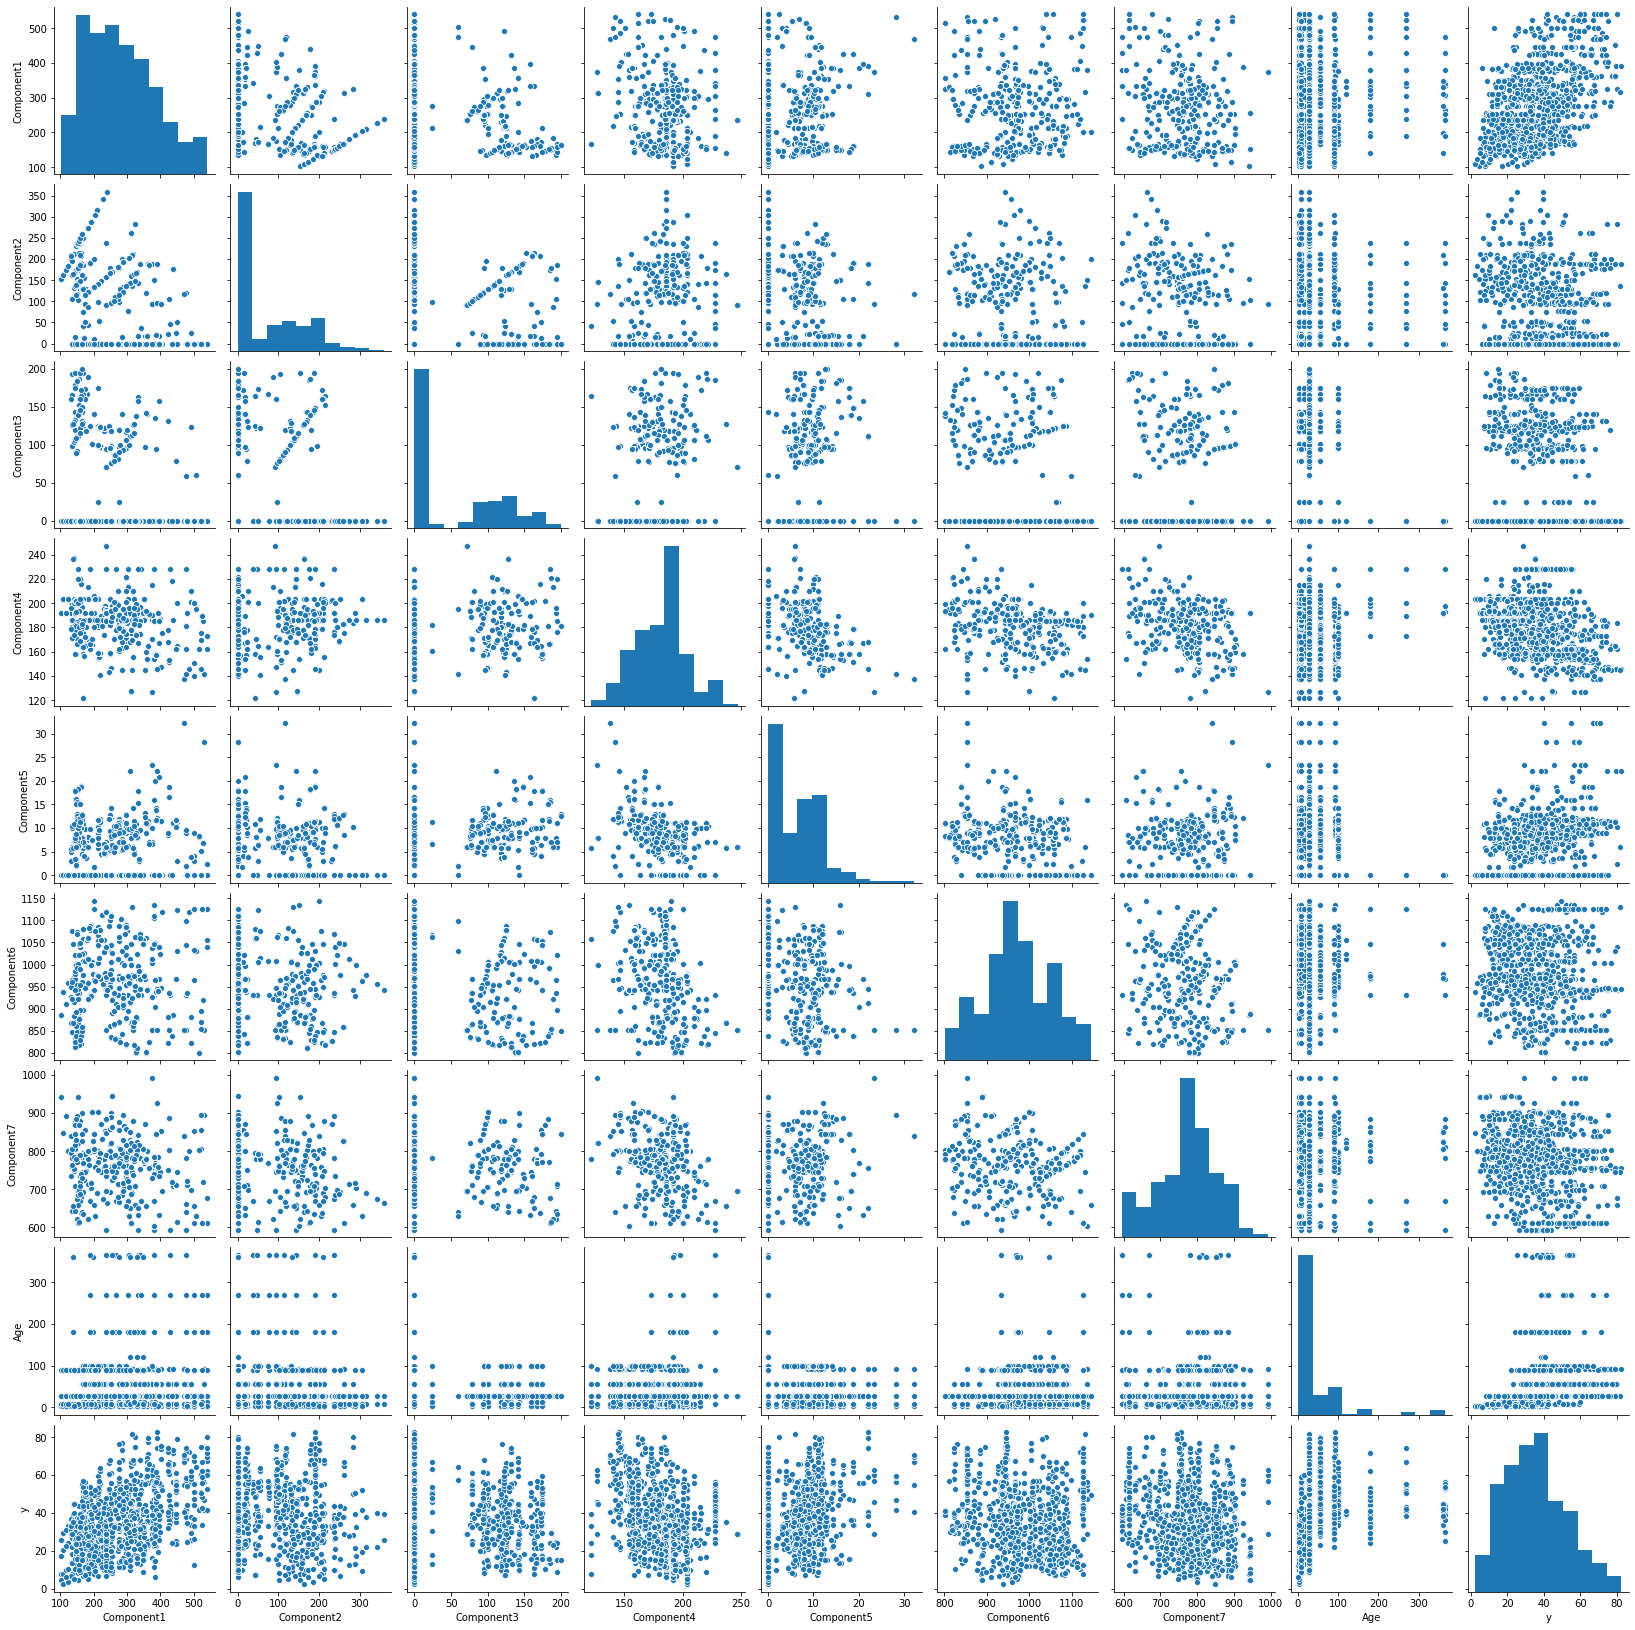

In [24]:
pairplot(df1)

### Correlation matrix and heatmap to visually check for [multicollinearity](https://en.wikipedia.org/wiki/Multicollinearity)

In [25]:
corr = df1[:-1].corr()

In [26]:
corr

,Component1,Component2,Component3,Component4,Component5,Component6,Component7,Age,y
Component1,1.000000,-0.275153,-0.397439,-0.081408,0.092856,-0.109725,-0.222755,0.081899,0.497813
Component2,-0.275153,1.000000,-0.323720,0.107065,0.043261,-0.283862,-0.281564,-0.044166,0.134895
Component3,-0.397439,-0.323720,1.000000,-0.257488,0.377248,-0.009475,0.079138,-0.154284,-0.105688
Component4,-0.081408,0.107065,-0.257488,1.000000,-0.658118,-0.181344,-0.450683,0.277965,-0.289554
Component5,0.092856,0.043261,0.377248,-0.658118,1.000000,-0.266031,0.222580,-0.192630,0.366218
Component6,-0.109725,-0.283862,-0.009475,-0.181344,-0.266031,1.000000,-0.178881,-0.003398,-0.165365
Component7,-0.222755,-0.281564,0.079138,-0.450683,0.222580,-0.178881,1.000000,-0.156143,-0.167284
Age,0.081899,-0.044166,-0.154284,0.277965,-0.192630,-0.003398,-0.156143,1.000000,0.328841
y,0.497813,0.134895,-0.105688,-0.289554,0.366218,-0.165365,-0.167284,0.328841,1.000000


In [27]:
from statsmodels.graphics.correlation import plot_corr

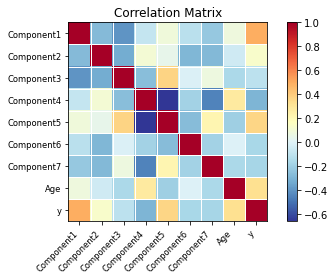

In [28]:
fig=plot_corr(corr,xnames=corr.columns)

### Creating a formula string for using in the `statsmodels.OLS()`

In [29]:
formula_str = df1.columns[-1]+' ~ '+'+'.join(df1.columns[:-1])

In [30]:
formula_str

'y ~ Component1+Component2+Component3+Component4+Component5+Component6+Component7+Age'

### Construct and fit the model. Print summary of the fitted model

In [31]:
model=sm.ols(formula=formula_str, data=df1)

In [32]:
fitted = model.fit()

In [33]:
print(fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.615
Model:                            OLS   Adj. R-squared:                  0.612
Method:                 Least Squares   F-statistic:                     204.3
Date:                Fri, 17 Jul 2020   Prob (F-statistic):          6.76e-206
Time:                        02:21:38   Log-Likelihood:                -3869.0
No. Observations:                1030   AIC:                             7756.
Df Residuals:                    1021   BIC:                             7800.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -23.1638     26.588     -0.871      0.3

### A new Result dataframe: p-values and statistical significance of the features 

In [34]:
df_result=pd.DataFrame()

In [35]:
df_result['pvalues']=fitted.pvalues[1:]

In [36]:
df_result['Features']=df.columns[:-1]

In [37]:
df_result.set_index('Features',inplace=True)

In [38]:
def yes_no(b):
    if b:
        return 'Yes'
    else:
        return 'No'

In [39]:
df_result['Statistically significant?']= df_result['pvalues'].apply(yes_no)

In [40]:
df_result

,pvalues,Statistically significant?
Features,,
Cement (component 1)(kg in a m^3 mixture),1.962842e-41,Yes
Blast Furnace Slag (component 2)(kg in a m^3 mixture),1.633083e-23,Yes
Fly Ash (component 3)(kg in a m^3 mixture),5.029952e-12,Yes
Water (component 4)(kg in a m^3 mixture),1.937337e-04,Yes
Superplasticizer (component 5)(kg in a m^3 mixture),1.920901e-03,Yes
Coarse Aggregate (component 6)(kg in a m^3 mixture),5.522656e-02,Yes
Fine Aggregate (component 7)(kg in a m^3 mixture),5.996805e-02,Yes
Age (day),5.841045e-82,Yes


#### All the predicting variables are statisticall significant with the [threshold of p-value <0.01](https://www.statsdirect.com/help/basics/p_values.htm)

### Residuals vs. predicting variables plots

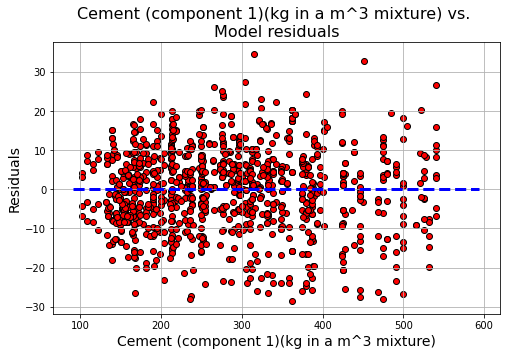

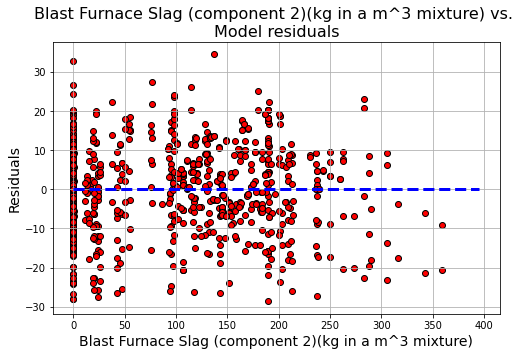

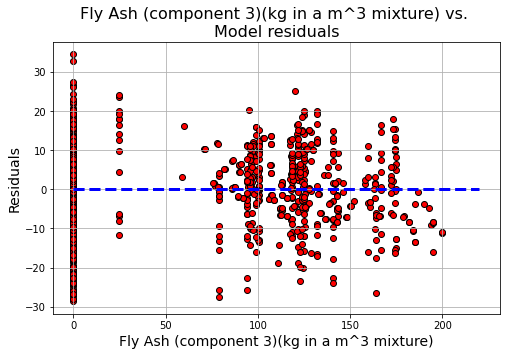

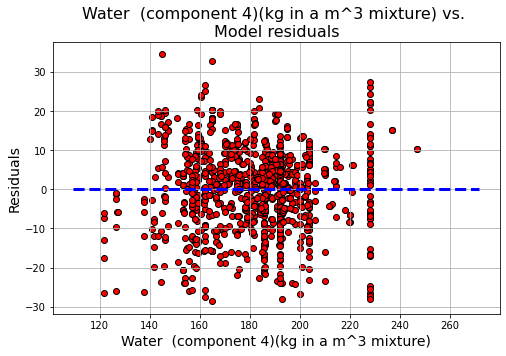

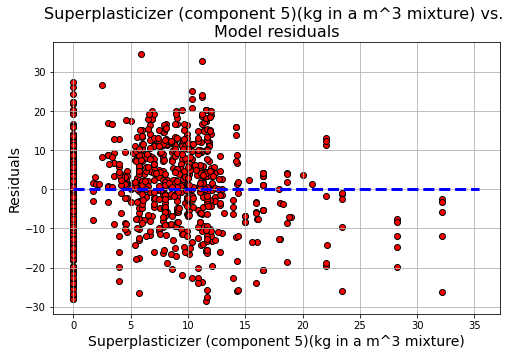

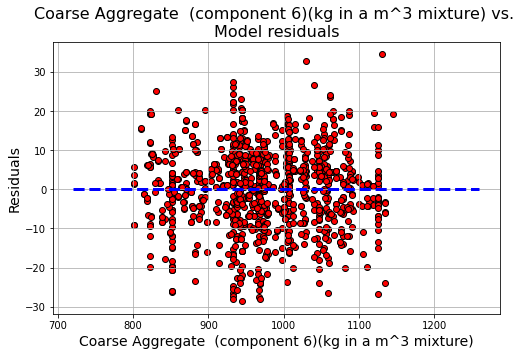

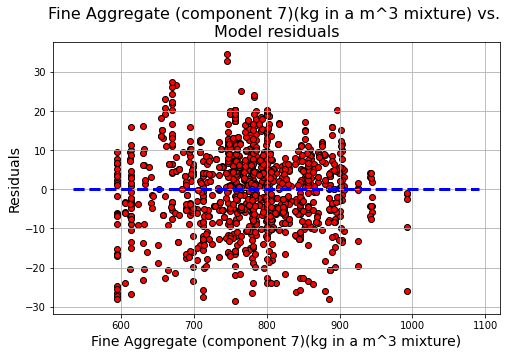

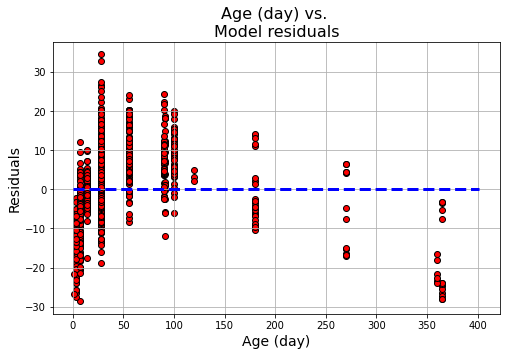

In [41]:
for c in df.columns[:-1]:
    plt.figure(figsize=(8,5))
    plt.title("{} vs. \nModel residuals".format(c),fontsize=16)
    plt.scatter(x=df[c],y=fitted.resid,color='red',edgecolor='k')
    plt.grid(True)
    xmin=min(df[c])
    xmax = max(df[c])
    plt.hlines(y=0,xmin=xmin*0.9,xmax=xmax*1.1,color='blue',linestyle='--',lw=3)
    plt.xlabel(c,fontsize=14)
    plt.ylabel('Residuals',fontsize=14)
    plt.show()

#### Residual plots show some bit of clustering but overall the assumptions linearity and independence seem to hold because the distribution seem random around the 0 axis.

### Fitted vs. residuals

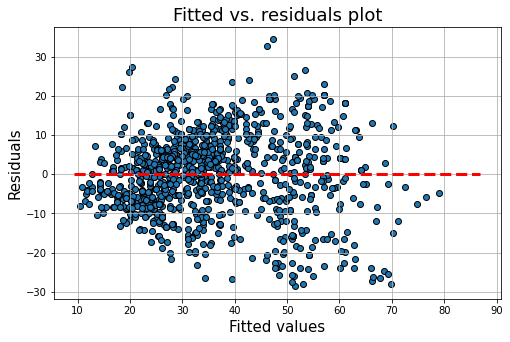

In [42]:
plt.figure(figsize=(8,5))
p=plt.scatter(x=fitted.fittedvalues,y=fitted.resid,edgecolor='k')
xmin=min(fitted.fittedvalues)
xmax = max(fitted.fittedvalues)
plt.hlines(y=0,xmin=xmin*0.9,xmax=xmax*1.1,color='red',linestyle='--',lw=3)
plt.xlabel("Fitted values",fontsize=15)
plt.ylabel("Residuals",fontsize=15)
plt.title("Fitted vs. residuals plot",fontsize=18)
plt.grid(True)
plt.show()

#### The fitted vs. residuals plot shows violation of the constant variance assumption - [Heteroscedasticity](http://www.statsmakemecry.com/smmctheblog/confusing-stats-terms-explained-heteroscedasticity-heteroske.html).

### Histogram of normalized residuals

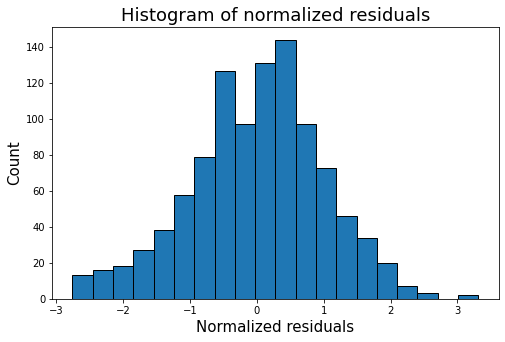

In [43]:
plt.figure(figsize=(8,5))
plt.hist(fitted.resid_pearson,bins=20,edgecolor='k')
plt.ylabel('Count',fontsize=15)
plt.xlabel('Normalized residuals',fontsize=15)
plt.title("Histogram of normalized residuals",fontsize=18)
plt.show()

### Q-Q plot of the residuals

In [44]:
from statsmodels.graphics.gofplots import qqplot

<Figure size 576x360 with 0 Axes>

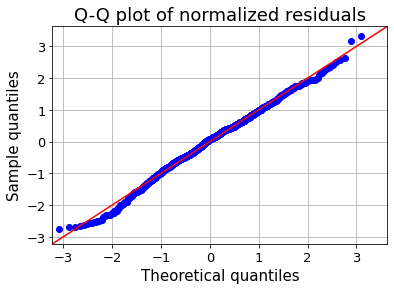

In [45]:
plt.figure(figsize=(8,5))
fig=qqplot(fitted.resid_pearson,line='45',fit='True')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel("Theoretical quantiles",fontsize=15)
plt.ylabel("Sample quantiles",fontsize=15)
plt.title("Q-Q plot of normalized residuals",fontsize=18)
plt.grid(True)
plt.show()

#### The Q-Q plot (and the histogram above) shows that the normality assumption is satisfied pretty good 

### Normality (Shapiro-Wilk) test of the residuals

In [46]:
from scipy.stats import shapiro

In [47]:
_,p=shapiro(fitted.resid)

In [48]:
if p<0.01:
    print("The residuals seem to come from Gaussian process")
else:
    print("The normality assumption may not hold")

The residuals seem to come from Gaussian process


### Cook's distance (checking for outliers in residuals)

In [49]:
from statsmodels.stats.outliers_influence import OLSInfluence as influence

In [50]:
inf=influence(fitted)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  after removing the cwd from sys.path.


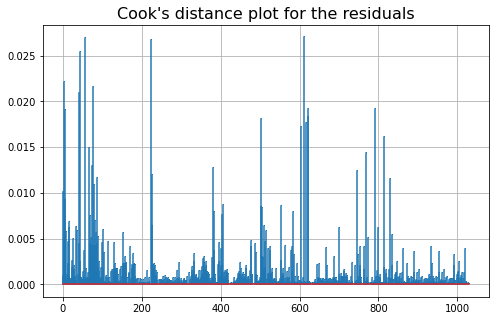

In [51]:
(c, p) = inf.cooks_distance
plt.figure(figsize=(8,5))
plt.title("Cook's distance plot for the residuals",fontsize=16)
plt.stem(np.arange(len(c)), c, markerfmt=",")
plt.grid(True)
plt.show()

#### There are few data points with residuals being possible outliers

### Variance inflation factor

In [52]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

In [53]:
for i in range(len(df1.columns[:-1])):
    v=vif(np.matrix(df1[:-1]),i)
    print("Variance inflation factor for {}: {}".format(df.columns[i],round(v,2)))

Variance inflation factor for Cement (component 1)(kg in a m^3 mixture): 26.23
Variance inflation factor for Blast Furnace Slag (component 2)(kg in a m^3 mixture): 4.44
Variance inflation factor for Fly Ash (component 3)(kg in a m^3 mixture): 4.56
Variance inflation factor for Water  (component 4)(kg in a m^3 mixture): 92.59
Variance inflation factor for Superplasticizer (component 5)(kg in a m^3 mixture): 5.52
Variance inflation factor for Coarse Aggregate  (component 6)(kg in a m^3 mixture): 85.97
Variance inflation factor for Fine Aggregate (component 7)(kg in a m^3 mixture): 73.46
Variance inflation factor for Age (day): 2.43


#### There are few features with VIF > 10, thereby indicating significant multicollinearity